In [1]:
# we naturally first need to import torch and torchvision
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
from datasets import load_dataset


def get_mnist_dataloaders(mnist_dataset, batch_size: int):
    pytorch_transforms = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

    # Prepare transformation functions
    def apply_transforms(batch):
        batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
        return batch

    mnist_train = mnist_dataset["train"].with_transform(apply_transforms)
    mnist_test = mnist_dataset["test"].with_transform(apply_transforms)

    # Construct PyTorch dataloaders
    trainloader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(mnist_test, batch_size=batch_size)
    return trainloader, testloader


# Download dataset
cifar = load_dataset("cifar10")

/Users/creamy/Research/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
cifar

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

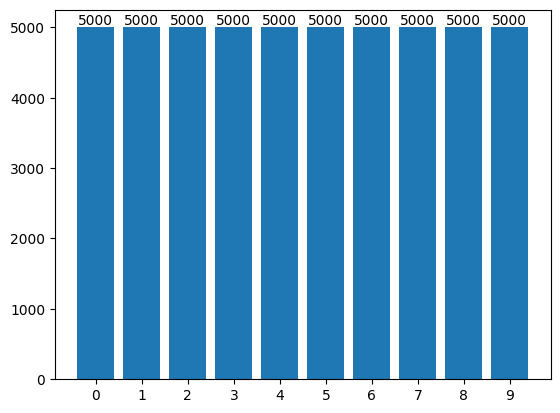

In [3]:
import matplotlib.pyplot as plt
from collections import Counter


# construct histogram
all_labels = cifar["train"]["label"]
all_label_counts = Counter(all_labels)

# visualise histogram
bar = plt.bar(all_label_counts.keys(), all_label_counts.values())
_ = plt.bar_label(bar)

# plot formatting
_ = plt.xticks([label for label in all_label_counts.keys()])

In [4]:
import random
import numpy as np
from PIL import Image
import io


def visualise_n_random_examples(trainset_, n: int, verbose: bool = True):
    trainset_data = [
        Image.open(io.BytesIO(entry[0].as_py())) for entry in trainset_.data[0]
    ]
    idx = list(range(len(trainset_data)))
    random.shuffle(idx)
    idx = idx[:n]
    if verbose:
        print(f"will display images with idx: {idx}")

    # construct canvas
    num_cols = 8
    num_rows = int(np.ceil(len(idx) / num_cols))
    fig, axs = plt.subplots(figsize=(16, num_rows * 2), nrows=num_rows, ncols=num_cols)

    # display images on canvas
    for c_i, i in enumerate(idx):
        axs.flat[c_i].imshow(trainset_data[i], cmap="gray")

will display images with idx: [45144, 39637, 3282, 37872, 43662, 37765, 4359, 2397, 6891, 15829, 10105, 15202, 14304, 463, 29246, 19111, 25692, 19756, 37413, 29095, 31681, 17488, 44756, 34967, 40887, 2504, 22268, 13531, 49454, 37223, 27225, 38221]


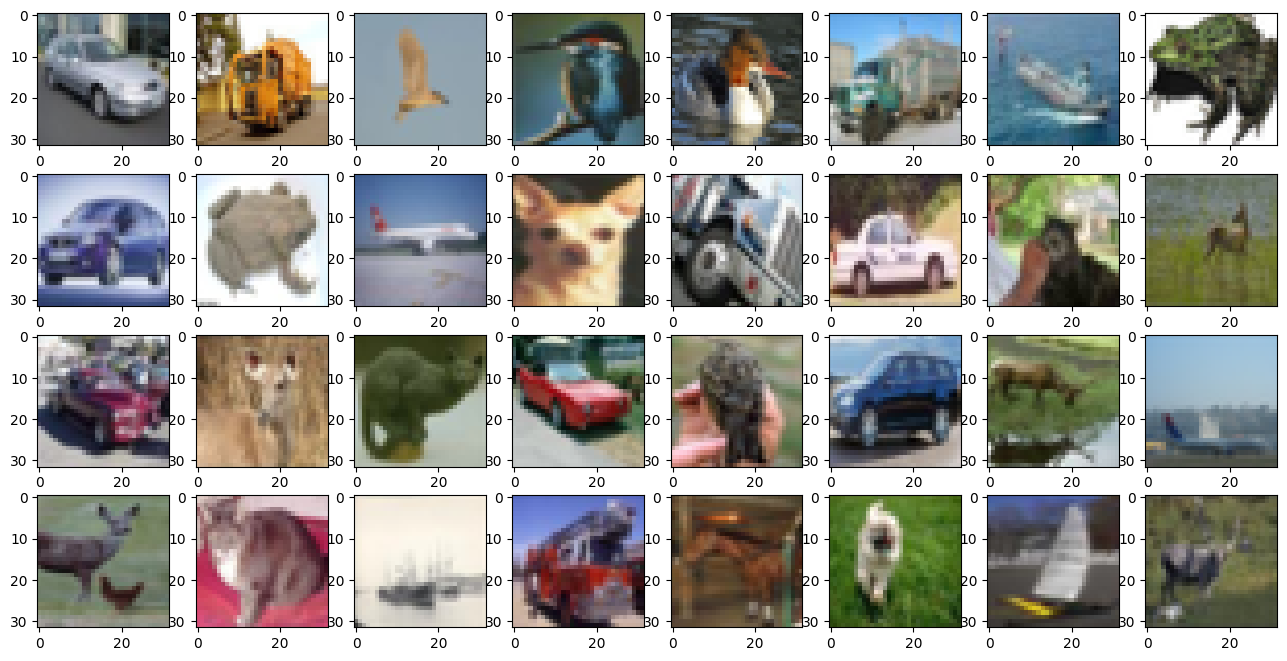

In [5]:
visualise_n_random_examples(cifar["train"], n=32)

# Client instead on Numpyclient

In [6]:
from collections import OrderedDict
from typing import List

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")

Training on cpu
Flower 1.18.0 / PyTorch 2.7.0


In [7]:
def load_datasets(partition_id: int, num_partitions: int):
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": num_partitions})
    partition = fds.load_partition(partition_id)
    # Divide data on each node: 80% train, 20% test
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    def apply_transforms(batch):
        # Instead of passing transforms to CIFAR10(..., transform=transform)
        # we will use this function to dataset.with_transform(apply_transforms)
        # The transforms object is exactly the same
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)
    trainloader = DataLoader(partition_train_test["train"], batch_size=32, shuffle=True)
    valloader = DataLoader(partition_train_test["test"], batch_size=32)
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=32)
    return trainloader, valloader, testloader

In [8]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [9]:
from io import BytesIO
from typing import cast

import numpy as np

from flwr.common.typing import NDArray, NDArrays, Parameters


def ndarrays_to_sparse_parameters(ndarrays: NDArrays) -> Parameters:
    """Convert NumPy ndarrays to parameters object."""
    tensors = [ndarray_to_sparse_bytes(ndarray) for ndarray in ndarrays]
    return Parameters(tensors=tensors, tensor_type="numpy.ndarray")


def sparse_parameters_to_ndarrays(parameters: Parameters) -> NDArrays:
    """Convert parameters object to NumPy ndarrays."""
    return [sparse_bytes_to_ndarray(tensor) for tensor in parameters.tensors]


def ndarray_to_sparse_bytes(ndarray: NDArray) -> bytes:
    """Serialize NumPy ndarray to bytes."""
    bytes_io = BytesIO()

    if len(ndarray.shape) > 1:
        # We convert our ndarray into a sparse matrix
        ndarray = torch.tensor(ndarray).to_sparse_csr()

        # And send it byutilizing the sparse matrix attributes
        # WARNING: NEVER set allow_pickle to true.
        # Reason: loading pickled data can execute arbitrary code
        # Source: https://numpy.org/doc/stable/reference/generated/numpy.save.html
        np.savez(
            bytes_io,  # type: ignore
            crow_indices=ndarray.crow_indices(),
            col_indices=ndarray.col_indices(),
            values=ndarray.values(),
            allow_pickle=False,
        )
    else:
        # WARNING: NEVER set allow_pickle to true.
        # Reason: loading pickled data can execute arbitrary code
        # Source: https://numpy.org/doc/stable/reference/generated/numpy.save.html
        np.save(bytes_io, ndarray, allow_pickle=False)
    return bytes_io.getvalue()


def sparse_bytes_to_ndarray(tensor: bytes) -> NDArray:
    """Deserialize NumPy ndarray from bytes."""
    bytes_io = BytesIO(tensor)
    # WARNING: NEVER set allow_pickle to true.
    # Reason: loading pickled data can execute arbitrary code
    # Source: https://numpy.org/doc/stable/reference/generated/numpy.load.html
    loader = np.load(bytes_io, allow_pickle=False)  # type: ignore

    if "crow_indices" in loader:
        # We convert our sparse matrix back to a ndarray, using the attributes we sent
        ndarray_deserialized = (
            torch.sparse_csr_tensor(
                crow_indices=loader["crow_indices"],
                col_indices=loader["col_indices"],
                values=loader["values"],
            )
            .to_dense()
            .numpy()
        )
    else:
        ndarray_deserialized = loader
    return cast(NDArray, ndarray_deserialized)

In [10]:
from flwr.common import (
    Code,
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    GetParametersIns,
    GetParametersRes,
    Status,
)


class FlowerClient(Client):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, ins: GetParametersIns) -> GetParametersRes:
        print(f"[Client {self.partition_id}] get_parameters")

        # Get parameters as a list of NumPy ndarray's
        ndarrays: List[np.ndarray] = get_parameters(self.net)

        # Serialize ndarray's into a Parameters object using our custom function
        parameters = ndarrays_to_sparse_parameters(ndarrays)

        # Build and return response
        status = Status(code=Code.OK, message="Success")
        return GetParametersRes(
            status=status,
            parameters=parameters,
        )

    def fit(self, ins: FitIns) -> FitRes:
        print(f"[Client {self.partition_id}] fit, config: {ins.config}")

        # Deserialize parameters to NumPy ndarray's using our custom function
        parameters_original = ins.parameters
        ndarrays_original = sparse_parameters_to_ndarrays(parameters_original)

        # Update local model, train, get updated parameters
        set_parameters(self.net, ndarrays_original)
        train(self.net, self.trainloader, epochs=1)
        ndarrays_updated = get_parameters(self.net)

        # Serialize ndarray's into a Parameters object using our custom function
        parameters_updated = ndarrays_to_sparse_parameters(ndarrays_updated)

        # Build and return response
        status = Status(code=Code.OK, message="Success")
        return FitRes(
            status=status,
            parameters=parameters_updated,
            num_examples=len(self.trainloader),
            metrics={},
        )

    def evaluate(self, ins: EvaluateIns) -> EvaluateRes:
        print(f"[Client {self.partition_id}] evaluate, config: {ins.config}")

        # Deserialize parameters to NumPy ndarray's using our custom function
        parameters_original = ins.parameters
        ndarrays_original = sparse_parameters_to_ndarrays(parameters_original)

        set_parameters(self.net, ndarrays_original)
        loss, accuracy = test(self.net, self.valloader)

        # Build and return response
        status = Status(code=Code.OK, message="Success")
        return EvaluateRes(
            status=status,
            loss=float(loss),
            num_examples=len(self.valloader),
            metrics={"accuracy": float(accuracy)},
        )


def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FlowerClient(partition_id, net, trainloader, valloader).to_client()
client = ClientApp(client_fn=client_fn)

In [11]:
from logging import WARNING
from typing import Callable, Dict, List, Optional, Tuple, Union

from flwr.common import FitRes, MetricsAggregationFn, NDArrays, Parameters, Scalar
from flwr.common.logger import log
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy import FedAvg
from flwr.server.strategy.aggregate import aggregate

WARNING_MIN_AVAILABLE_CLIENTS_TOO_LOW = """
Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.
"""

class FedSparse(FedAvg):
    def __init__(
        self,
        *,
        fraction_fit: float = 0.05,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, Dict[str, Scalar]],
                Optional[Tuple[float, Dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
    ) -> None:
        """Custom FedAvg strategy with sparse matrices.

        Parameters
        ----------
        fraction_fit : float, optional
            Fraction of clients used during training. Defaults to 0.1.
        fraction_evaluate : float, optional
            Fraction of clients used during validation. Defaults to 0.1.
        min_fit_clients : int, optional
            Minimum number of clients used during training. Defaults to 2.
        min_evaluate_clients : int, optional
            Minimum number of clients used during validation. Defaults to 2.
        min_available_clients : int, optional
            Minimum number of total clients in the system. Defaults to 2.
        evaluate_fn : Optional[Callable[[int, NDArrays, Dict[str, Scalar]], Optional[Tuple[float, Dict[str, Scalar]]]]]
            Optional function used for validation. Defaults to None.
        on_fit_config_fn : Callable[[int], Dict[str, Scalar]], optional
            Function used to configure training. Defaults to None.
        on_evaluate_config_fn : Callable[[int], Dict[str, Scalar]], optional
            Function used to configure validation. Defaults to None.
        accept_failures : bool, optional
            Whether or not accept rounds containing failures. Defaults to True.
        initial_parameters : Parameters, optional
            Initial global model parameters.
        """

        if (
            min_fit_clients > min_available_clients
            or min_evaluate_clients > min_available_clients
        ):
            log(WARNING, WARNING_MIN_AVAILABLE_CLIENTS_TOO_LOW)

        super().__init__(
            fraction_fit=fraction_fit,
            fraction_evaluate=fraction_evaluate,
            min_fit_clients=min_fit_clients,
            min_evaluate_clients=min_evaluate_clients,
            min_available_clients=min_available_clients,
            evaluate_fn=evaluate_fn,
            on_fit_config_fn=on_fit_config_fn,
            on_evaluate_config_fn=on_evaluate_config_fn,
            accept_failures=accept_failures,
            initial_parameters=initial_parameters,
            fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        )

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None

        # We deserialize using our custom method
        parameters_ndarrays = sparse_parameters_to_ndarrays(parameters)

        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        loss, metrics = eval_res
        return loss, metrics

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        if not results:
            return None, {}
        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            return None, {}

        # We deserialize each of the results with our custom method
        weights_results = [
            (sparse_parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]

        # We serialize the aggregated result using our custom method
        parameters_aggregated = ndarrays_to_sparse_parameters(
            aggregate(weights_results)
        )

        # Aggregate custom metrics if aggregation fn was provided
        metrics_aggregated = {}
        if self.fit_metrics_aggregation_fn:
            fit_metrics = [(res.num_examples, res.metrics) for _, res in results]
            metrics_aggregated = self.fit_metrics_aggregation_fn(fit_metrics)
        elif server_round == 1:  # Only log this warning once
            log(WARNING, "No fit_metrics_aggregation_fn provided")

        return parameters_aggregated, metrics_aggregated

In [12]:
def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=3)
    return ServerAppComponents(
        config=config,
        strategy=FedSparse(),  # <-- pass the new strategy here
    )
backend_config = {"client_resources": None}
if DEVICE.type == "cuda":
    backend_config = {"client_resources": {"num_gpus": 1}}

NUM_PARTITIONS = 10
# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=3, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(raylet) /Users/creamy/Research/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
(raylet)   warnings.warn(
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 2 clients (out of 10)
(ClientAppActor pid=55303) /var/folders/p2/nbbt6dzn06nb2mts7wwsgpzm0000gn/T/ipykernel_54675/4041256762.py:26: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request t

(ClientAppActor pid=55303) [Client 8] get_parameters
(ClientAppActor pid=55303) [Client 1] fit, config: {}
(ClientAppActor pid=55303) Epoch 1: train loss 0.0653112605214119, accuracy 0.21825
(ClientAppActor pid=55301) [Client 7] fit, config: {}


(ClientAppActor pid=55301) /var/folders/p2/nbbt6dzn06nb2mts7wwsgpzm0000gn/T/ipykernel_54675/4041256762.py:58: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
INFO :      aggregate_fit: received 2 results and 0 failures
/var/folders/p2/nbbt6dzn06nb2mts7wwsgpzm0000gn/T/ipykernel_54675/4041256762.py:58: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  torch.sparse_csr_tensor(
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=55301) Epoch 1: train loss 0.06529015302658081, accuracy 0.217
(ClientAppActor pid=55303) [Client 1] evaluate, config: {}
(ClientAppActor pid=55303) [Client 4] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=55302) /var/folders/p2/nbbt6dzn06nb2mts7wwsgpzm0000gn/T/ipykernel_54675/4041256762.py:58: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)


(ClientAppActor pid=55303) [Client 6] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 2 clients (out of 10)


(ClientAppActor pid=55301) [Client 9] fit, config: {}
(ClientAppActor pid=55300) [Client 8] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=55301) Epoch 1: train loss 0.057068146765232086, accuracy 0.32825


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=55300) [Client 5] fit, config: {}
(ClientAppActor pid=55301) [Client 3] evaluate, config: {}
(ClientAppActor pid=55300) Epoch 1: train loss 0.057912297546863556, accuracy 0.29875
(ClientAppActor pid=55303) [Client 5] evaluate, config: {}
(ClientAppActor pid=55301) [Client 1] evaluate, config: {} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 2 clients (out of 10)


(ClientAppActor pid=55301) [Client 7] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=55303) [Client 9] fit, config: {}
(ClientAppActor pid=55303) [Client 9] evaluate, config: {}
(ClientAppActor pid=55303) Epoch 1: train loss 0.0534009225666523, accuracy 0.36975


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=55302) HTTP Error 429 thrown while requesting HEAD https://huggingface.co/datasets/cifar10/resolve/main/README.md
(ClientAppActor pid=55302) Retrying in 1s [Retry 1/5].
(ClientAppActor pid=55300) /var/folders/p2/nbbt6dzn06nb2mts7wwsgpzm0000gn/T/ipykernel_54675/4041256762.py:58: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
(ClientAppActor pid=55302) HTTP Error 429 thrown while requesting HEAD https://huggingface.co/datasets/cifar10/resolve/main/README.md [repeated 12x across cluster]
(ClientAppActor pid=55302) Retrying in 8s [Retry 4/5]. [repeated 12x across cluster]
(ClientAppActor

(ClientAppActor pid=55302) [Client 2] evaluate, config: {}
(ClientAppActor pid=55301) [Client 1] fit, config: {}
(ClientAppActor pid=55301) Epoch 1: train loss 0.05428873747587204, accuracy 0.3575
(ClientAppActor pid=55301) [Client 6] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=55300) [Client 9] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 round(s) in 136.73s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.0611865489602089
INFO :      		round 2: 0.055565855526924134
INFO :      		round 3: 0.0531266896367073
INFO :      


(ClientAppActor pid=55301) [Client 8] evaluate, config: {}


(ClientAppActor pid=55301) HTTP Error 429 thrown while requesting HEAD https://huggingface.co/datasets/cifar10/resolve/0b2714987fa478483af9968de7c934580d0bb9a2/cifar10.py [repeated 3x across cluster]
(ClientAppActor pid=55301) Retrying in 8s [Retry 4/5]. [repeated 3x across cluster]
